# Try to look at the vessels in the delineated patches of the hearts
Ruslan/Tim delineated the patch region in the hearts.
Let's repeat what we did with the `Vessels.ipynb` notebook, but only for the delineated patch regions.

In [1]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import pandas
import platform
import os
import glob
import numpy
from tqdm import notebook
from itkwidgets import view  # 3d viewer
import imageio
import skimage
import skimage.morphology
import scipy.stats
import dask
import dask.array as da
import dask_image.imread
from dask.distributed import Client
client = Client()
from numcodecs import Blosc

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51297 instead


In [2]:
print('You can see what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can see what DASK is doing at "http://localhost:51297/status"


In [3]:
# Ignore warnings in the notebook
#import warnings
#warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (14, 7)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'


The validate_legend_loc function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [6]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [8]:
platform.system()

'Darwin'

In [9]:
# What are we working with?
the_current_git_hash = get_git_hash()
print('We are working with version %s of the analyis notebook.'
      % the_current_git_hash)

We are working with version 32ae2dc of the analyis notebook.


In [10]:
# Generate the output folder
# Including the git hash, so we (potentially) have different versions of all the images we generate
OutputDir = os.path.join('Output', the_current_git_hash)
os.makedirs(OutputDir, exist_ok=True)

In [11]:
# Different locations if running either on Linux or Windows
if 'anaklin25' in platform.node():
    FastSSD = True
else:
    FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Volumes/2TBSSD/')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Hearts Melly')
print('We are loading all the data from %s' % Root)

We are loading all the data from /Volumes/2TBSSD/Hearts Melly


In [12]:
import tempfile

print(tempfile.gettempdir())

/var/folders/nc/fh66knbx263cxr7t7t1qx4j80000gn/T


In [13]:
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = os.path.join('/Volumes/2TBSSD/')
else:
    tmp = os.path.join('F:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'dask_tmp')})

In [14]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [15]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [16]:
# Get *all* log files
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True))]

In [17]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [18]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [19]:
# Drop all folders we don't need
for c, row in Data.iterrows():
    if 'Rat' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'Test' in row.Folder:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [20]:
# Get some data from folders
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Animal'] = [int(s.replace('Rat', '').replace('b', '')) for s in Data['Sample']]
Data['Scan'] = [l[len(Root)+1:].split(os.sep)[1] for l in Data['LogFile']]

In [21]:
# From Ludovics mail
# R60/61 : W1, VP (VEGF + PDGF = both growth factors) 
# R62/63 : W1, F    (=fibrin only = empty patch)
# R64/65 : W1, Tachosil only (negative control)

# R66/68 : W4, VP (VEGF + PDGF = both growth factors) 
# R67/69 : W4, F    (=fibrin only = empty patch)
# R70/71 : W4, Tachosil only (negative control)

In [22]:
# Read in table from Ludovic with animal details (Mail from 18.2.2021)
Animals = pandas.read_excel('Animals.xlsx',
                            header=None,
                            names=('Animal', 'Sex', '', 'Experiment', 'Timepoint'))

In [23]:
Data = pandas.merge(Data, Animals)

In [24]:
# Exclusion from Tims visual inspection
# R63
# R65
# R66
# R70
#exclude = [63, 65, 66, 70]

In [25]:
# Drop samples which should be excluded
Data = Data[Data["Scan"] == 'cu_10um']
Data.reset_index(drop=True, inplace=True)

In [26]:
# Get voxelsize from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [27]:
# Detect what's in the VOI folders
for sample in Data.Sample.unique():
    for folder in ['_patch', '_myocard']:
        # print(os.path.join(Root, sample, 'cu_10um', '*' + folder))
        if not len(glob.glob(os.path.join(Root, sample, 'cu_10um', '*' + folder, '*.png'))):
            print('%s contains *no* PNG files' % glob.glob(os.path.join(Root, sample, 'cu_10um', '*' + folder))[0])

/Volumes/2TBSSD/Hearts Melly/Rat80/cu_10um/voi_patch contains *no* PNG files
/Volumes/2TBSSD/Hearts Melly/Rat80/cu_10um/voi_myocard contains *no* PNG files
/Volumes/2TBSSD/Hearts Melly/Rat81/cu_10um/voi_patch contains *no* PNG files
/Volumes/2TBSSD/Hearts Melly/Rat81/cu_10um/voi_myocard contains *no* PNG files


In [28]:
# Detect VOI files
for sample in Data.Sample.unique():
    for folder in ['_patch', '_myocard']:
        if len(glob.glob(os.path.join(Root, sample, 'cu_10um', '*' + folder, '*.roi'))) != 1:
            print('%s does *not* contain a .roi files' % glob.glob(os.path.join(Root, sample, 'cu_10um', '*' + folder))[0])

/Volumes/2TBSSD/Hearts Melly/Rat80/cu_10um/voi_patch does *not* contain a .roi files
/Volumes/2TBSSD/Hearts Melly/Rat80/cu_10um/voi_myocard does *not* contain a .roi files
/Volumes/2TBSSD/Hearts Melly/Rat81/cu_10um/voi_patch does *not* contain a .roi files
/Volumes/2TBSSD/Hearts Melly/Rat81/cu_10um/voi_myocard does *not* contain a .roi files


In [29]:
# List of VOI files
Data['VOIFilesPatch'] = [sorted(glob.glob(os.path.join(Root, sample, scan, 'voi_patch', '*.png')))
                         for (sample, scan)
                         in zip(Data['Sample'], Data['Scan'])]
Data['VOIFilesMyocard'] = [sorted(glob.glob(os.path.join(Root, sample, scan, 'voi_myocard', '*.png')))
                         for (sample, scan)
                         in zip(Data['Sample'], Data['Scan'])]

In [30]:
# Delete empties
# https://stackoverflow.com/a/13851602/323100
Data = Data[Data["VOIFilesPatch"].map(len) > 0]
Data.reset_index(drop=True, inplace=True)

In [31]:
# Convert all patch VOI slices into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOIPatch'] = [os.path.join(Root, sample, scan, sample + '_voi_patch.zarr')
                              for sample, scan
                              in zip(Data['Sample'], Data['Scan'])]
for c, row in notebook.tqdm(Data.iterrows(), total=len(Data)):
    if not os.path.exists(row['OutputNameVOIPatch']):
        if len(row['VOIFilesPatch']):
            print('%2s/%s: Reading %s VOI slices from %s and saving to %s' % (c + 1,
                                                                              len(Data),
                                                                              len(row['VOIFilesPatch']),
                                                                              os.path.join(row['Sample'],
                                                                                           row['Scan'],
                                                                                           'voi_patch'),
                                                                              row['OutputNameVOIPatch'][len(Root):]))
            Reconstructions = dask_image.imread.imread(os.path.join(os.path.commonpath(row['VOIFilesPatch']), '*.png'))
            Reconstructions.rechunk(100).to_zarr(row['OutputNameVOIPatch'],
                                    overwrite=True,
                                    compressor=Blosc(cname='zstd',
                                                    clevel=3,
                                                    shuffle=Blosc.BITSHUFFLE))
        else:
            print('%2s/%s: NO VOI slices found for patch of %s' % (c + 1,
                                                                   len(Data),
                                                                   row['Sample']))
            Data.at[c, 'OutputNameVOIPatch'] = ''

In [32]:
# Convert all myocard VOI slices into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameVOIMyocard'] = [os.path.join(Root, sample, scan, sample + '_voi_myocard.zarr')
                                for sample, scan
                                in zip(Data['Sample'], Data['Scan'])]
for c, row in notebook.tqdm(Data.iterrows(), total=len(Data)):
    if not os.path.exists(row['OutputNameVOIMyocard']):
        if len(row['VOIFilesMyocard']):
            print('%2s/%s: Reading %s VOI slices from %s and saving to %s' % (c + 1,
                                                                              len(Data),
                                                                              len(row['VOIFilesMyocard']),
                                                                              os.path.join(row['Sample'],
                                                                                           row['Scan'],
                                                                                           'voi_myocard'),
                                                                              row['OutputNameVOIMyocard'][len(Root):]))
            Reconstructions = dask_image.imread.imread(os.path.join(os.path.commonpath(row['VOIFilesMyocard']), '*.png'))
            Reconstructions.rechunk(100).to_zarr(row['OutputNameVOIMyocard'],
                                                 overwrite=True,
                                                 compressor=Blosc(cname='zstd',
                                                                  clevel=3,
                                                                  shuffle=Blosc.BITSHUFFLE))
        else:
            print('%2s/%s: NO VOI slices found for myocard of %s' % (c + 1,
                                                                     len(Data),
                                                                     row['Sample']))
            Data.at[c, 'OutputNameVOIMyocard'] = ''

In [33]:
# Load the reconstructions as zarr arrays
Patch = [dask.array.from_zarr(file) if file else numpy.nan for file in Data['OutputNameVOIPatch']]
Myocard = [dask.array.from_zarr(file) if file else numpy.nan for file in Data['OutputNameVOIMyocard']]

In [35]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [36]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_Patch' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs Patch', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      total=len(directions),
                                      leave=False):
        outfilepath = os.path.join(Root,
                                   row['Sample'],
                                   row['Scan'],
                                   '%s.MIP.%s.Patch.png' % (row['Sample'], direction))  
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_Patch' + direction] = imageio.imread(outfilepath)
        else:
            try:
                # Generate MIP
                Data.at[c, 'MIP_Patch' + direction] = Patch[c].max(axis=d).compute()
                # Save it out
                imageio.imwrite(outfilepath, Data.at[c, 'MIP_Patch' + direction].astype('uint8'))
            except AttributeError:
                # No MIP to calculate
                Data.at[c, 'MIP_Patch' + direction] = numpy.nan

In [37]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_Myocard' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs Patch', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      total=len(directions),
                                      leave=False):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'],
                                   '%s.MIP.%s.Myocard.png' % (row['Sample'], direction))       
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_Myocard' + direction] = imageio.imread(outfilepath)
        else:
            try:
                # Generate MIP
                Data.at[c, 'MIP_Myocard' + direction] = Patch[c].max(axis=d).compute()
                # Save it out
                imageio.imwrite(outfilepath, Data.at[c, 'MIP_Myocard' + direction].astype('uint8'))
            except AttributeError:
                # No MIP to calculate
                Data.at[c, 'MIP_Myocard' + direction] = numpy.nan

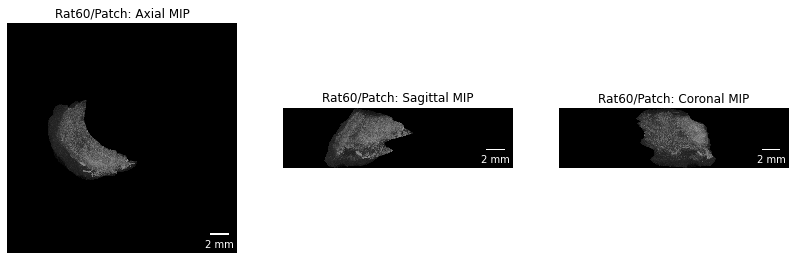

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


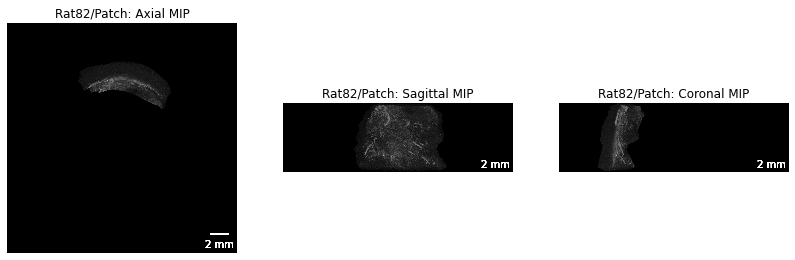

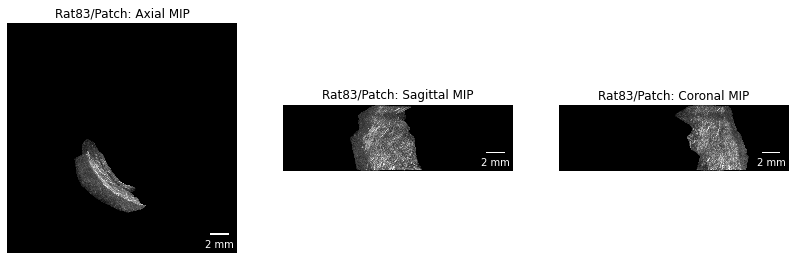

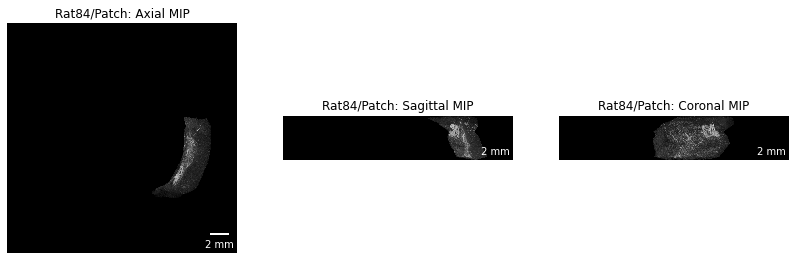

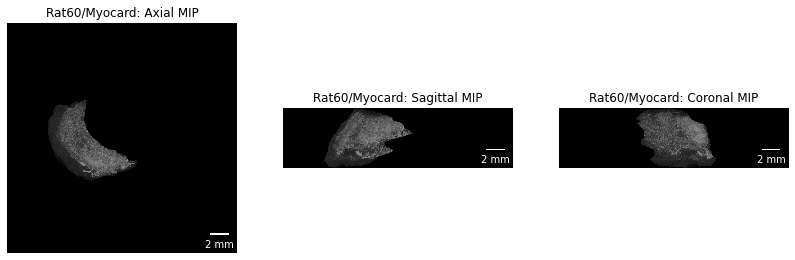

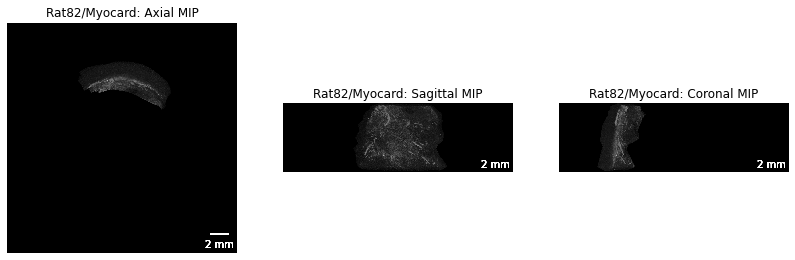

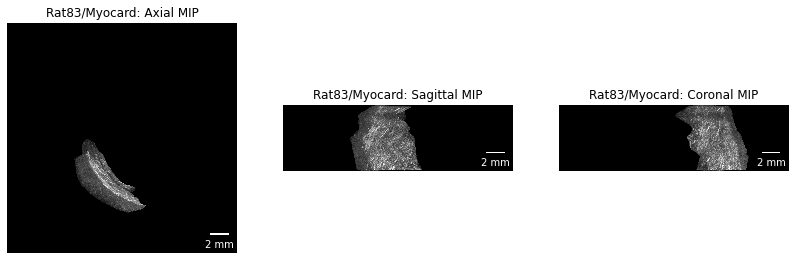

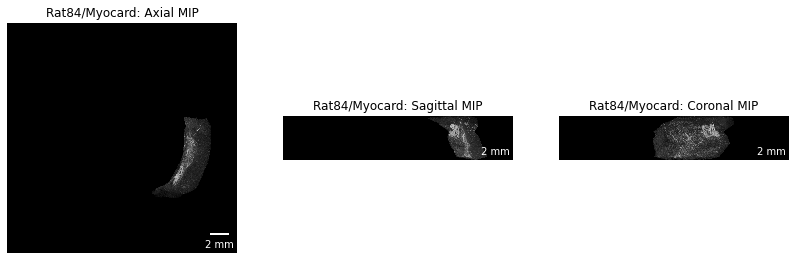

In [38]:
# Show MIP slices
for voi in ('Patch', 'Myocard'):
    for c, row in Data.iterrows():
        outfilepath = os.path.join(Root,
                                   row['Sample'],
                                   row['Scan'],
                                   row['Sample'] + '.MIPs.' + voi + '.png')
        for d, direction in enumerate(directions):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + voi + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s: %s' % (os.path.join(row['Sample'], voi), 
                                  direction + ' MIP'))

            plt.axis('off')
        if not os.path.exists(outfilepath):
            plt.savefig(outfilepath, bbox_inches='tight')
            plt.show()

In [39]:
# Calculate the difference between the delineations from Tim
Data['OutputNameVOISubMyocard'] = [os.path.join(Root, sample, scan, sample + '_voi_submyocard.zarr')
                                   for sample, scan
                                   in zip(Data['Sample'], Data['Scan'])]
for c, row in notebook.tqdm(Data.iterrows(), total=len(Data)):
    if not os.path.exists(row['OutputNameVOISubMyocard']):
        print('%2s/%s: Calculating submyocard by subtracting patch'
              ' from myocard and saving to %s' % (c + 1,
                                                  len(Data),
                                                  row['OutputNameVOISubMyocard'][len(Root):]))
        SubMyocard = Myocard[c] - Patch[c]
        SubMyocard.rechunk(100).to_zarr(row['OutputNameVOISubMyocard'],
                               overwrite=True,
                               compressor=Blosc(cname='zstd',
                                                clevel=3,
                                                shuffle=Blosc.BITSHUFFLE))

 1/11: Calculating submyocard by subtracting patch from myocard and saving to /Rat60/cu_10um/Rat60_voi_submyocard.zarr
 2/11: Calculating submyocard by subtracting patch from myocard and saving to /Rat61/cu_10um/Rat61_voi_submyocard.zarr
 8/11: Calculating submyocard by subtracting patch from myocard and saving to /Rat69/cu_10um/Rat69_voi_submyocard.zarr
 9/11: Calculating submyocard by subtracting patch from myocard and saving to /Rat82/cu_10um/Rat82_voi_submyocard.zarr
10/11: Calculating submyocard by subtracting patch from myocard and saving to /Rat83/cu_10um/Rat83_voi_submyocard.zarr
11/11: Calculating submyocard by subtracting patch from myocard and saving to /Rat84/cu_10um/Rat84_voi_submyocard.zarr



In [41]:
# Load the data
SubMyocard = [dask.array.from_zarr(file) for file in Data['OutputNameVOISubMyocard']]

In [40]:
asdfasdfasdf==

SyntaxError: invalid syntax (<ipython-input-40-f9fc12050b0e>, line 1)

In [ ]:
# Prepare histograms
HistogramPatch = [dask.array.histogram(ptch, bins=255, range=[0, 255]) for ptch in Patch]
HistogramMyocard = [dask.array.histogram(myc, bins=255, range=[0, 255]) for myc in Myocard]
HistogramSubMyocard = [dask.array.histogram(myc, bins=255, range=[0, 255]) for myc in SubMyocard]

In [ ]:
plt.subplot(131)
for c,h in enumerate(HistogramPatch):
    plt.semilogy(h[0], label=Data.Animal[c])
plt.xlim([0,255])
plt.legend()
plt.title('Histograms patch')
plt.subplot(132)
for c,h in enumerate(HistogramMyocard):
    plt.semilogy(h[0], label=Data.Animal[c])
plt.xlim([0,255])
plt.legend()
plt.title('Histograms myocard')
plt.subplot(133)
for c,h in enumerate(HistogramSubMyocard):
    plt.semilogy(h[0], label=Data.Animal[c])
plt.xlim([0,255])
plt.legend()
plt.title('Histograms submyocard')
plt.show()

In [ ]:
# Save out submyocard slices
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving out myocard slices',
                            total=len(Data)):
    os.makedirs(os.path.join(Root, row.Sample, row.Scan, 'voi_submyocard'),
                exist_ok=True)
    for d, rec in notebook.tqdm(enumerate(SubMyocard[c]),
                                total=len(SubMyocard[c]),
                                desc=row.Sample,
                                leave=False):
        filename = os.path.join(Root,
                                row.Sample,
                                row.Scan,
                                'voi_submyocard',
                                os.path.basename(row.VOIFilesMyocard[d]))
        if not os.path.exists(filename):
            imageio.imsave(filename, rec.astype('uint8'))

In [ ]:
for i in Data:
    print(i)

The `mean` gray value needs to be calculated and 'calibrated' to the total volume of the ROI

In [ ]:
# Mask the outside of the ROI that Tim drew
MaskedPatch = [da.ma.masked_equal(v, 0) for v in Patch]
MaskedMyocard = [da.ma.masked_equal(v, 0) for v in Myocard]
MaskedSubMyocard = [da.ma.masked_equal(v, 0) for v in Patch]

In [ ]:
# How large are the VOIs from Tim?
# We select/mask everything non-zero and fill this whith one.
RegionPatch = [da.ma.filled(da.ma.masked_not_equal(v, 0), 1) for v in Patch]
# By summing it, we get the volume
Data['VolumePatch'] = [rp.sum().compute() for rp in RegionPatch]

In [ ]:
for c,e in enumerate(Data.Experiment.unique()):
    print(c,e)

In [ ]:
# Plot volume of VOIs for comparison
import random
seaborn.swarmplot(data=Data,
                  x='Timepoint', y='VolumePatch', hue='Experiment',
                  s=10, linewidth=1.5)
for i, tp in enumerate(Data['Timepoint'].unique()):
    for j, row in Data[Data['Timepoint'] == tp].iterrows():
        plt.annotate(row['Sample'],
                     xy=(i + 0.025 * j, row['VolumePatch']))
plt.ylim(ymin=0)   
plt.title('Volume of the individual VOIs')
plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
Data.Timepoint.unique()

In [ ]:
seaborn.lmplot(data=Data,
               x='Timepoint', y='VolumePatch', hue='Experiment', x_jitter=1)
plt.gca().set_xticks(Data.Timepoint.unique())
plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.Regression.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
seaborn.catplot(data=Data, x='Experiment', y='VolumePatch', hue='Timepoint')
plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.Experiment.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
seaborn.lmplot(data=Data,
               x='Timepoint', y='VolumePatch', hue='Experiment', col='Experiment')
plt.gca().set_xticks(Data.Timepoint.unique())
plt.savefig(os.path.join(OutputDir, 'Volume.VOIs.Separated.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
OutputDir

In [ ]:
Data[['Sample', 'VolumePatch']].to_excel(os.path.join(OutputDir, 'Volume.Patches.xls'))

In [ ]:
Data.groupby(by=['Experiment'])['VolumePatch'].describe()[['count',
                                                           'mean',
                                                           'std',
                                                           'min',
                                                           'max']]

In [ ]:
# Save mean of reconstruction gray values, which we can use for getting an overview of the image data
Data['GrayValueMeanPatch'] = [p.mean().compute() for p in Patch]
Data['GrayValueMeanMyocard'] = [m.mean().compute() for m in Myocard]
Data['GrayValueMeanSubMyocard'] = [sm.mean().compute() for sm in SubMyocard]

In [ ]:
# Plot grayvalue mean of datasets for comparison
plt.subplot(131)
seaborn.swarmplot(data=Data,
                  x='Timepoint', y='GrayValueMeanPatch',
                  hue='Experiment', s=10, linewidth=1.5, dodge=True)
plt.title('Average grayvalue in the patch')
# plt.ylim([0,5])
plt.subplot(132)
seaborn.swarmplot(data=Data,
                  x='Timepoint', y='GrayValueMeanMyocard',
                  hue='Experiment', s=10, linewidth=1.5, dodge=True)
plt.title('in the myocard')
# plt.ylim([0,5])
plt.subplot(133)
seaborn.swarmplot(data=Data,
                  x='Timepoint', y='GrayValueMeanSubMyocard',
                  hue='Experiment', s=10, linewidth=1.5, dodge=True)
plt.title('in the sub-yocard')
# plt.ylim([0,5])
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.VOIs.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
Data[['Sample',
      'GrayValueMeanPatch',
      'GrayValueMeanMyocard',
      'GrayValueMeanSubMyocard']].to_excel(os.path.join(OutputDir, 'Grayvalues.Mean.VOIs.xls'))

In [ ]:
Data.groupby(by=['Experiment'])['GrayValueMeanPatch'].describe()[['count',
                                                                  'mean',
                                                                  'std',
                                                                  'min',
                                                                  'max']]

In [ ]:
Data.groupby(by=['Experiment'])['GrayValueMeanMyocard'].describe()[['count',
                                                                    'mean',
                                                                    'std',
                                                                    'min',
                                                                    'max']]

In [ ]:
Data.groupby(by=['Experiment'])['GrayValueMeanSubMyocard'].describe()[['count',
                                                                       'mean',
                                                                       'std',
                                                                       'min',
                                                                       'max']]

In [ ]:
Data['GrayValueMeanNormalizedToVOIVolume'] = [dask.array.divide(gvm,
                                                                vv) for gvm, vv in zip(Data['GrayValueMeanPatch'],
                                                                                       Data['VolumePatch'])]

In [ ]:
# Plot volume-normalized mean of datasets for comparison
#seaborn.boxplot(data=Data, x='Experiment', y='GrayValueMeanNormalizedToVOIVolume', hue='Timepoint')
seaborn.swarmplot(data=Data,
                  x='Timepoint', y='GrayValueMeanNormalizedToVOIVolume',
                  hue='Experiment', linewidth=1.5, s=10)
for i, tp in enumerate(Data['Timepoint'].unique()):
    for j, row in Data[Data['Timepoint'] == tp].iterrows():
        plt.annotate(row['Sample'],
                     xy=(i+0.025*j, row['GrayValueMeanNormalizedToVOIVolume']))
plt.ylim(ymin=0, ymax=1.1*Data.GrayValueMeanNormalizedToVOIVolume.max())
plt.title('Average grayvalue in the volumes of interest normalized to size of volume of interest')
plt.savefig(os.path.join(OutputDir, 'Grayvalues.Mean.NormalizedVOI.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
# # Save STD of reconstruction gray values, which we can use for getting an overview of the image data
Data['GrayValueSTD'] = [m.std().compute() for m in MaskedPatch]

In [ ]:
# Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Experiment', y='GrayValueSTD')
seaborn.swarmplot(data=Data, x='Experiment', y='GrayValueSTD', linewidth=1.5, s=10, color='gray')
plt.ylim(ymin=0)
plt.show()

In [ ]:
# def calculate_threshold(img, verbose=False):
#     '''
#     Calculate (Otsu) threshold of a stack, with some nice output if desired
#     '''
#     if len(numpy.shape(img)) != 3:
#         print('Only works with a 3D stack')
#         return()
#     if verbose:
#         print('The stack we use has a size of %s x %s x %s px' % numpy.shape(img))
#     threshold = skimage.filters.threshold_otsu(dask.array.ravel(img.compute()))
#     if verbose:
#         seaborn.distplot(img.ravel())
#         plt.axvline(threshold, label='Otsu@%s' % threshold, c=seaborn.color_palette()[1])
#         plt.axvline(numpy.mean(img), label='Image mean@%0.2f' % img.mean(), c=seaborn.color_palette()[2])
#         plt.legend()
#         plt.semilogy()
#         plt.xlim([0,255])
#         plt.show()
#     return(threshold.compute())

In [ ]:
# # https://stackoverflow.com/a/38086839
# h,bins=dask.array.histogram(VOIs[0], bins=range(0,255,4))
# plt.semilogy(h)
# plt.show()

In [ ]:
# Thresholds
preset = True
if preset:
    # Set them (from previous calculations)
    Data['Threshold'] = [13, 63, 15, 4, 5, 5, 5, 8, 25, 7, 40, 16]
#    Data['Threshold'] = [44, 46, 41, 16, 12, 15, 63, 16, 15, 18, 13, 13]
#     Data['Threshold'] = [41, 45, 41, 12, 13, 19, 13]
else:
    # Calculate Threshold
    Data['Threshold'] = [skimage.filters.threshold_otsu(
        dask.array.ravel(
            dask.array.ma.masked_less(
                rec, 1).compute())) for rec in Patch]

In [ ]:
list(Data.Threshold)

In [ ]:
# Get the mean threshold of all samples
Data['ThresholdMean'] = int(Data['Threshold'].mean())

In [ ]:
Data['ThresholdMean']

In [ ]:
# Plot the thresholds
seaborn.swarmplot(data=Data, x='Experiment', y='Threshold', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.Threshold))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.Threshold))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.Threshold))
plt.axhline(Data['ThresholdMean'].mean(), label='Mean threshold @ %s' % Data['ThresholdMean'].mean())
plt.ylim(ymin=0)
plt.legend()
plt.title('Otsu thresholds of individual VOIs')
plt.savefig(os.path.join(OutputDir, 'Thresholds.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
Data[['Sample', 'Threshold']].to_excel(os.path.join(OutputDir, 'Thresholds.xls'))

In [ ]:
Data.groupby(by=['Experiment'])['Threshold'].describe()[['count',
                                                         'mean',
                                                         'std',
                                                         'min',
                                                         'max']]

In [ ]:
# Threshold the reconstructions individually                                                                                                                           Data.Sample)
Data['OutputNameThresholded'] = [f.replace('.zarr',
                                           '_thresholded_%s.zarr' % str(t).zfill(3)) for f, t in zip(Data['OutputNameVOIPatch'],
                                                                                                     Data['Threshold'])]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholded']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameThresholded'][len(Root):]))
    else:
        print('%2s/%s: Thresholding and saving to %s' % (c + 1,
                                                         len(Data),
                                                         row['OutputNameThresholded'][len(Root):]))
        Thresholded = Patch[c] > row['Threshold']
        Thresholded.rechunk(100).to_zarr(row['OutputNameThresholded'],
                           overwrite=True,
                           compressor=Blosc(cname='zstd',
                                            clevel=3,
                                            shuffle=Blosc.BITSHUFFLE))    

In [ ]:
# Threshold the reconstructions with the mean threshold                                                                                                                           Data.Sample)
Data['OutputNameThresholdedMean'] = [f.replace('.zarr',
                                           '_thresholded_%s.zarr' % str(t).zfill(3)) for f, t in zip(Data['OutputNameVOIPatch'],
                                                                                                     Data['ThresholdMean'])]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameThresholdedMean']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameThresholdedMean'][len(Root):]))
    else:
        print('%2s/%s: Thresholding and saving to %s' % (c + 1,
                                                         len(Data),
                                                         row['OutputNameThresholded'][len(Root):]))
        Thresholded = Patch[c] > row['ThresholdMean']
        Thresholded.rechunk(100).to_zarr(row['OutputNameThresholdedMean'],
                           overwrite=True,
                           compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))    

In [ ]:
# Load the DASK arrays of the thresholded samples
individualThreshold = False
if individualThreshold:
    Thresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholded']]
    print('Loading individually thresholded stacks')
else:
    Thresholded = [dask.array.from_zarr(file) for file in Data['OutputNameThresholdedMean']]
    print('Loading all stacks with a threshold of %s' % Data.ThresholdMean.unique())

In [ ]:
# Read or calculate the directional MIPs of the thresholded datasets,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Thresholded_MIP_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'], '%s.Thresholded.MIP.%s.png' % (row['Sample'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Thresholded_MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'Thresholded_MIP_' + direction] = Thresholded[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'Thresholded_MIP_' + direction].astype('uint8'))            

In [ ]:
# Show thresholded MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Thresholded_MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s, %s' % (row['Sample'], direction + ' MIP'))
        plt.axis('off')
    plt.savefig(os.path.join(Root, row['Sample'], row['Scan'], row['Sample'] + '.Thresholded.MIPs.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Sum the images, so we can see if they contain approximately the same *thresholded* volume
Data['ThresholdedVolume'] = [th.sum().compute() for th in Thresholded]

In [ ]:
# Data[['Sample', 'ThresholdedVolume']]

In [ ]:
# Plot the thresholded volumes
seaborn.swarmplot(data=Data, x='Experiment', y='ThresholdedVolume', hue='Timepoint', dodge=True, linewidth=1.5, s=10)
for c,row in Data.iterrows():
    if 'VP' in row.Experiment:
        plt.annotate(row.Sample, (0, row.ThresholdedVolume))
    elif 'F' in row.Experiment:
        plt.annotate(row.Sample, (1, row.ThresholdedVolume))
    elif 'Tacho' in row.Experiment:
        plt.annotate(row.Sample, (2, row.ThresholdedVolume))
plt.ylim(ymin=0)
if individualThreshold:
    plt.title('Volume of the individually thresholded images, corresponding to the total thresholded volume')
    plt.savefig(os.path.join(OutputDir, 'Volumes.Thresholded.ThresholdedIndividually.png'),
                bbox_inches='tight')    
else:
    plt.title('Volume of the images thresholded all equally, corresponding to the total thresholded volume')    
    plt.savefig(os.path.join(OutputDir, 'Volumes.Thresholded.ThresholdedEqually.png'),
                bbox_inches='tight')    
plt.show()

In [ ]:
OutputDir

In [ ]:
Data[['Sample', 'Experiment', 'Threshold', 'ThresholdedVolume',
      'GrayValueMeanPatch', 'GrayValueMeanMyocard', 'GrayValueMeanSubMyocard']]

# Characterization of vessel diameter
- Fill the vessels/ventricle (with something like `skimage.fill.small.holes`)
    This doesn't seem to be working in the 3D case (maybe because of small holes) but we just loop through every slice and do it for each and everyone of it. This is bad code, but works :)
- Remove all the big stuff with `tophat`
- Calculate the distance-transformation or skeleton

In [ ]:
def ourfiller(image, verbose=False):
    '''
    Since we cannot seem to get remove_small_holes to work in 3D, we simply brute-force it on every slice.
    Thanks to `tqdm_notebook` we also get a progress bar...
    And afterwards generate an output array.
    '''
    filled = [skimage.morphology.remove_small_holes(s, area_threshold=1e4) for
              s in tqdm.notebook.tqdm(image, leave=False)]
    if verbose:
        plt.subplot(131)
        plt.imshow(image[len(filled)//2,:,:])
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(filled[len(filled)//2,:,:])       
        plt.title('Filled (output)')
        plt.subplot(133)        
        plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
        plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
        plt.title('Overlay')        
        plt.show()    
    return(filled)

In [ ]:
# def pad_edges(image, howmanypixels=25):
#     '''There *has* to be a better way to set the edges to one, but I havent found one'''
#     closed = image.copy()
#     closed[:howmanypixels,:,:] = True
#     closed[:,:howmanypixels,:] = True
#     closed[:,:,:howmanypixels] = True
#     closed[-howmanypixels:,:,:] = True
#     closed[:,-howmanypixels:,:] = True
#     closed[:,:,-howmanypixels:] = True
#     return(closed)

In [ ]:
# def fill_hollow_bones(image, verbose=False):
#     '''
#     We flood-fill the image from one edge.
#     Then we add the inversion of this to the original image and thus filled all the long bones.
#     '''
#     dilated = skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(image)))
#     closed = pad_edges(dilated)
#     # Flood fill from one edge and invert the (boolean) result
#     flooded = ~skimage.morphology.flood_fill(closed.astype('int'),
#                                              seed_point=(30,30,30),
#                                              new_value=1).astype('bool')
#     # Add the inverted result to the original image, filling the long bones
#     filled = numpy.add(image, skimage.morphology.binary_dilation(
#         skimage.morphology.binary_dilation(
#             skimage.morphology.binary_dilation(flooded))))
#     if verbose:
#         plt.subplot(131)
#         plt.imshow(image[len(filled)//2,:,:])
#         plt.title('original')
#         plt.subplot(132)
#         plt.imshow(flooded[len(filled)//2,:,:])       
#         plt.title('flooded')
#         plt.subplot(133)        
#         plt.imshow(image[len(filled)//2,:,:], alpha=0.5)       
#         plt.imshow(filled[len(filled)//2,:,:], cmap='viridis', alpha=0.5)       
#         plt.title('filled (output)')        
#         plt.show()
#     return(filled)

In [ ]:
# Calculate the flood-filled image
# Since this takes a while, we don't do it in a Pythonic way
# e.g. (Flooded = [ourfiller(t, verbose=True) for t in Tresholded])
# but in a loop with saving in between.
Data['OutputNameFlooded'] = [f.replace('.zarr', '_flooded.zarr') for f in Data['OutputNameThresholded']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameFlooded']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameFlooded'][len(Root):]))
    else:
        print('%2s/%s: %s: Filling holes' % (c + 1,
                                             len(Data),
                                             row['Sample']))
        Flooded = ourfiller(Thresholded[c].compute())
        Flooded = da.stack(Flooded[:])
        print('%11s: Saving to %s' % (row['Sample'],
                                     row['OutputNameFlooded'][len(Root):]))
        Flooded.rechunk(100).to_zarr(row['OutputNameFlooded'],
                        overwrite=True,
                        compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

In [ ]:
# Load the DASK arrays with the filled samples
Flooded = [dask.array.from_zarr(file) for file in Data['OutputNameFlooded']]

In [ ]:
# DASK
# Read or calculate the middle slices of the flooded images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Flooded_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(),
                                 desc='Middle flooded images',
                                 total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'],
                                   '%s.Thresholded%03d.Flooded.Middle.%s.png' % (row['Sample'],
                                                                                 row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Flooded_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Flooded_Mid_' + direction] = Flooded[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,
                            (Data.at[c,'Flooded_Mid_' + direction].astype('uint8')*255))

In [ ]:
# Show middle flood-filled images
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(Root, row['Sample'], row['Scan'], row['Sample'] + '.Flooded.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()    

In [ ]:
# Show middle flood-filled images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(Root, row['Sample'], row['Scan'], row['Sample'] + '.Flooded.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# plt.imshow(Data['Thresholded_Mid_Axial'][0])
# plt.imshow(dask.array.ma.masked_less(Data['Flooded_Mid_Axial'][0], 1), alpha=0.5, cmap='viridis')

In [ ]:
# Show middle axis flooded images
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# plt.subplot(121)
# plt.imshow(Data['Thresholded_Mid_' + direction][1])
# plt.subplot(122)
# plt.imshow(Data['Flooded_Mid_' + direction][1])

In [ ]:
Flooded[0]

In [ ]:
Reconstructions[0]

In [ ]:
# Get the white tophat
# https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.white_tophat
# e.g. the bright spots of the image that are smaller than the structuring element.
# We use a ball-shaped (sphere) structuring element
# Again, since this takes a *long* while, we don't do it nice and pythonic,
# but in a loop with intermediate saving
# e.g. not (Tophat = [skimage.morphology.white_tophat(f, selem=skimage.morphology.ball(7)) for f in Flooded])
# but
tophatselem = 5
Data['OutputNameTophat'] = [f.replace('.zarr', '_tophat_%s.zarr' % tophatselem) for f in Data['OutputNameFlooded']]
Tophat = [numpy.nan for file in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameTophat']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameTophat'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating white thophat with a "selem" of %s' % (c + 1,
                                                                              len(Data),
                                                                              row['Sample'],
                                                                              tophatselem))
        Tophat = skimage.morphology.white_tophat(Flooded[c].compute(),
                                                 selem=skimage.morphology.ball(tophatselem))
        Tophat = da.stack(Tophat[:])        
        print('%11s: Saving to %s' % (row['Sample'],
                                      row['OutputNameTophat'][len(Root):]))
        Tophat.rechunk(100).to_zarr(row['OutputNameTophat'],
                       overwrite=True,
                       compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

In [ ]:
#img = Thresholded[1][1250:-1350,100:-100,100:-100].compute()

In [ ]:
# 2D
#tophat = skimage.morphology.white_tophat(a, selem=skimage.morphology.disk(33))

In [ ]:
# 2D
#plt.subplot(131)
#plt.imshow(a)
#plt.subplot(132)
#plt.imshow(tophat)
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(a,
#                             tophat), alpha=0.5)
#plt.imshow(tophat, cmap='viridis', alpha=0.5)
#plt.show()

In [ ]:
# Calculate 3D topat
#tophat = skimage.morphology.white_tophat(img, selem=skimage.morphology.ball(11))

In [ ]:
#whichslice = numpy.shape(img)[0]//2
#plt.subplot(131)
#plt.imshow(img[whichslice])
#plt.subplot(132)
#plt.imshow(tophat[whichslice])
#plt.subplot(133)
#plt.imshow(numpy.bitwise_xor(img[whichslice],
#                             tophat[whichslice]), alpha=0.5)
#plt.imshow(tophat[whichslice], cmap='viridis', alpha=0.5)

In [ ]:
# Load the DASK arrays with the tophat-filtered samples (e.g. only containing the smaller vessels)
Tophat = [dask.array.from_zarr(file) for file in Data['OutputNameTophat']]

In [ ]:
# DASK
# Read or calculate the middle slices of the Tophat images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Tophat_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle tophat images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'],
                                   '%s.Thresholded%03d.Tophat.Middle.%s.png' % (row['Sample'],
                                                                                row['Threshold'],
                                                                                 direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Tophat_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Tophat_Mid_' + direction] = Tophat[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, (Data.at[c,'Tophat_Mid_' + direction].astype('uint8')*255))

In [ ]:
# Show middle flood-filled images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Tophat_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Thresholded_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(Root, row['Sample'], row['Scan'], row['Sample'] + '.Tophat.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Show middle slices of tophat data
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Thresholded_Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Tophat_Mid_' + direction], 1), alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of tophat of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# Show overlay
# for c, direction in enumerate(directions):
#     print(c, direction)    
#     if c:
#         plt.imshow(numpy.rot90(center, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(numpy.rot90(flooded, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(numpy.rot90(tophat, axes=(0,c))[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     else:
#         plt.imshow(center[len(flooded)//2,:,:], alpha=0.33)
#         plt.imshow(flooded[len(flooded)//2,:,:], alpha=0.33, cmap='magma')
#         plt.imshow(tophat[len(flooded)//2,:,:], alpha=0.33, cmap='viridis')
#     plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0], 'um'))
#     plt.axis('off')
#     plt.savefig('Overlay-%s.png' % direction, bbox_inches='tight')  
#     plt.show()

In [ ]:
# Calculate the skeletonization
# By multiplying them later on we get a color-coded medial axis transformation
# This conforms to what we would expect from 'skimage.morphology.medial_axis(image, return_distance=True)' which does *not* work for 3D images
Data['OutputNameSkeleton'] = [f.replace('.zarr', '_skeleton.zarr') for f in Data['OutputNameTophat']]
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkeleton']):  
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkeleton'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating skeletonization' % (c + 1,
                                                           len(Data),
                                                           row['Sample']))
        Skeleton = skimage.morphology.skeletonize_3d(Tophat[c])
        Skeleton = da.stack(Skeleton[:])
        print('%11s: Saving to %s' % (row['Sample'],
                                      row['OutputNameSkeleton'][len(Root):]))
        Skeleton.rechunk(100).to_zarr(row['OutputNameSkeleton'],
                         overwrite=True,
                         compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))          

In [ ]:
# Load the DASK arrays with the skeletonized images
Skeleton = [dask.array.from_zarr(file) for file in Data['OutputNameSkeleton']]

In [ ]:
# Read or calculate the middle slices of the Skeletonization images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Skeleton_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle skeleton images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'],
                                   '%s.Thresholded%03d.Skeleton.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'Skeleton_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'Skeleton_Mid_' + direction] = Skeleton[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath, Data.at[c,'Skeleton_Mid_' + direction].astype('uint8'))

In [ ]:
# Show middle skeletonized images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction])
        plt.imshow(dask.array.ma.masked_less(row['Skeleton_Mid_' + direction], 1), alpha=0.5, cmap='viridis')        
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(Root, row['Sample'], row['Scan'], row['Sample'] + '.Skeleton.Overlay.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Tophat_Mid_' + direction])
        plt.imshow(row['Skeleton_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of Skeletonization of\n%s together with tophat' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
#a, b = scipy.ndimage.morphology.distance_transform_edt(Tophat[0][900:1000], sampling=10)

In [ ]:
#numpy.shape(a)

In [ ]:
#plt.imshow(a[5])

In [ ]:
#Tophat[0][800:-800,800:-800,800:-800]

In [ ]:
Tophat[1]

In [ ]:
Data[['Folder',
      'Sample',
#       'Scan',
      'SampleNameLength',
      'ScanNameLength',
      'Experiment',
      'Timepoint',
      'LogFile',
#       'VOIFolders',
      'VOIFolder',
      'Voxelsize',
#       'VOISlices',
      'Number of VOI slices',
      'Size',
      'VOIVolume',
      'GrayValueMean',
      'GrayValueMeanNormalizedToVOIVolume',
      'Threshold',
      'ThresholdMean',
      'ThresholdedVolume',
      'GrayValueMeanNormalizedToThresholdedVolume']].to_excel(os.path.join(OutputDir, 'Data_' + get_git_hash() + '.xls'))

In [ ]:
# for i in Data:
#     print(i)

In [ ]:
# Calculate the euclidean distance transformation
subsampling = None
if subsampling:
    Data['OutputNameEDT'] = [f.replace('.zarr', '_edt_sampling%s.zarr' % subsampling) for f in Data['OutputNameTophat']]
else:
    Data['OutputNameEDT'] = [f.replace('.zarr', '_edt.zarr') for f in Data['OutputNameTophat']]    
# Calculate EDT
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameEDT']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameEDT'][len(Root):]))
    else:
        print('%2s/%s: %s: Calculating euclidean distance transformation' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'].rjust(Data['SampleNameLength'].max())))
        EDT = scipy.ndimage.morphology.distance_transform_edt(Tophat[c].astype('bool'),
                                                              sampling=subsampling)
        EDT = da.stack(EDT[:])
        print('%11s: Saving to %s' % (row['Sample'].rjust(Data['SampleNameLength'].max()),
                                      row['OutputNameEDT']))
        EDT.rechunk(100).to_zarr(row['OutputNameEDT'],
                    overwrite=True,
                    compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load in the EDT from the saved zarr files   
EDT = [dask.array.from_zarr(file) for file in Data['OutputNameEDT']]

In [ ]:
# DASK
# Read or calculate the middle slices of the EDT images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['EDT_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle EDT images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                           desc=row['Sample'],
                                           leave=False,
                                           total=len(directions)):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'],
                                   '%s.Thresholded%03d.EDT.Middle.%s.png' % (row['Sample'],
                                                                             row['Threshold'],
                                                                             direction))
        if os.path.exists(outfilepath):
            Data.at[c,'EDT_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'EDT_Mid_' + direction] = EDT[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'EDT_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Flooded_Mid_' + direction])
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['EDT_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of EDT of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# Show middle skeletonized images with overlay
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['EDT_Mid_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
#         plt.title('%s/%s: %s, %s' % (c + 1,
#                                      len(Data),
#                                      row['Sample'],
#                                      direction + ' MIP'))
        plt.title('%s: %s' % (row['Sample'],
                              direction + ' MIP'))
        
        plt.axis('off')
    plt.savefig(os.path.join(Root, row['Sample'], row['Scan'], row['Sample'] + '.EDT.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Calculate distance on skeleton
Data['OutputNameSkelDist'] = [f.replace('.zarr', '_skeletondistance.zarr') for f in Data['OutputNameTophat']]
# Calculate edt
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameSkelDist']):
        print('%2s/%s: Already saved to %s' % (c + 1,
                                               len(Data),
                                               row['OutputNameSkelDist'][len(Root):]))
    else:
        print('%2s/%s: %s: Multiplying skeleton and EDT and saving to %s' % (c + 1,
                                                                             len(Data),
                                                                             row['Sample'].rjust(Data['SampleNameLength'].max()),
                                                                             row['OutputNameSkelDist'][len(Root):]))
        SkelDist = numpy.multiply(Skeleton[c], EDT[c])
        SkelDist.rechunk(100).to_zarr(row['OutputNameSkelDist'],
                         overwrite=True,
                         compressor=Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE))

In [ ]:
# Load the DASK arrays with the skeleton-distance
SkelDist = [dask.array.from_zarr(file) for file in Data['OutputNameSkelDist']]

In [ ]:
# DASK
# Read or calculate the middle slices of the SkelDist images,
# put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['SkelDist_Mid_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='Middle SkelDist images', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'],
                                   '%s.Thresholded%03d.SkelDist.Middle.%s.png' % (row['Sample'],
                                                                                  row['Threshold'],
                                                                                  direction))
        if os.path.exists(outfilepath):
            Data.at[c,'SkelDist_Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][Data['Size'][c][0]//2]
            if 'Sagittal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,Data['Size'][c][1]//2,:]
            if 'Coronal' in direction:
                Data.at[c,'SkelDist_Mid_' + direction] = SkelDist[c][:,:,Data['Size'][c][2]//2]
            # Save the calculated 'direction' view out
            # Dask only calculates/reads the images here at this point...
            imageio.imwrite(outfilepath,Data.at[c,'SkelDist_Mid_' + direction].astype('uint8'))

In [ ]:
for d,direction in enumerate(directions):
    for c,row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
#         plt.imshow(row['Thresholded_Mid_' + direction])
#         plt.imshow(dask.array.ma.masked_where(0, row['EDT_Mid_' + direction]), alpha=0.5, cmap='viridis')
        plt.imshow(row['SkelDist_Mid_' + direction], alpha=0.5, cmap='viridis')
        plt.title('Middle %s slice of SkelDist of\n%s together with original' % (direction, row['Sample']))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))    
        plt.axis('off')
    plt.show()

In [ ]:
# sl = 999
# plt.subplot(131)
# plt.imshow(numpy.max(Skeleton[0], axis=0), cmap='viridis')
# plt.subplot(132)
# plt.imshow(numpy.max(EDT[0], axis=0), cmap='viridis')
# plt.subplot(133)
# plt.imshow(numpy.max(SkelDist[0], axis=0), cmap='viridis')
# plt.show()

In [ ]:
# Read or calculate skeletondistance MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_SkelDist_' + direction] = [None] * len(VOIs)
for c, row in tqdm.notebook.tqdm(Data.iterrows(), desc='MIPs SkelDist', total=len(Data)):
    for d, direction in tqdm.notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(Root, row['Sample'], row['Scan'],
                                   '%s.Thresholded%03d.MIP.SkelDist.%s.png' % (row['Sample'],
                                                                               row['Threshold'],
                                                                               direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_SkelDist_' + direction] = imageio.imread(outfilepath)
        else:
            # Keep *this* reconstruction in RAM for a bit
            img = SkelDist[c].astype('uint8').persist()
            # Generate MIP
            Data.at[c,'MIP_SkelDist_' + direction] = img.max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath,
                            Data.at[c,'MIP_SkelDist_' + direction])

In [ ]:
for i, row in Data.iterrows():
    for j, direction in enumerate(directions):
        plt.subplot(1,3,j+1)
#         plt.imshow(row['MIP_' + direction], alpha=0.5)
#         plt.imshow(dask.array.ma.masked_less(row['MIP_SkelDist_' + direction],1), cmap='viridis')        
        plt.imshow(row['MIP_SkelDist_' + direction], cmap='viridis')            
        plt.title('%s view' % direction)
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))                
        plt.axis('off')        
    plt.suptitle('%02d/%02d: MIP with Skeleton overlay %s' % (i+1, len(Data), row['Sample']))
    plt.savefig(os.path.join(Root, row['Sample'], row['Scan'], row['Sample'] + '.SkelDist.MiddleSlices.png'),
                bbox_inches='tight')    
    plt.show()

In [ ]:
SkelDist[0].max().compute()

In [ ]:
Data['SkelDistMean'] = [dask.array.mean(skldst).compute() for skldst in SkelDist]

In [ ]:
Data.head()

In [ ]:
Data['SkelDistMeanNormalized'] = [dask.array.mean(skldst).compute()/tv for skldst, tv in zip(SkelDist, Data['ThresholdedVolume'])]

In [ ]:
Data['SkelDistSTD'] = [dask.array.std(skldst).compute() for skldst in SkelDist]

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMean')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMean', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance.png'))
plt.show()

In [ ]:
# Plot mean of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistMeanNormalized')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistMeanNormalized', linewidth=1.5, s=10, color='gray');
plt.ylabel('Mean Skeleton distance value, normalized to thresholded volume')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_Normalized.png'))
plt.show()

In [ ]:
# Plot STD of datasets for comparison
seaborn.catplot(data=Data, kind='box', x='Sample', y='SkelDistSTD')
seaborn.swarmplot(data=Data, x='Sample', y='SkelDistSTD', linewidth=1.5, s=10, color='gray');
plt.ylabel('Skeleton distance STD')
plt.ylim(ymin=0)
plt.savefig(os.path.join(OutputDir,
                         'Skeleton_Average_Distance_STD.png'))
plt.show()